# Initialize system

In [ ]:
### Setup the library ###
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
import math
import pprint
import inspect 
top_level=f'{os.getcwd()}/../'
rootTopLevel = top_level+'script/'
pr.addLibraryPath( rootTopLevel )

import setupLibPaths

import ePix320kM as devBoard

args = None

# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

In [ ]:
# ONLY RUN ONCE!
# Defining root
root =  devBoard.Root(   
        top_level  = rootTopLevel,
        dev        = '/dev/datadev_0',
        pollEn     = False,
        initRead   = True,
        serverPort = 9099)
root.start()

# example showing a read
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

In [ ]:
# Useful short names
APP  = root.App
AXIV = root.Core.AxiVersion
ASICTOP = APP.AsicTop
TRIG = ASICTOP.TriggerRegisters
ASIC0 = APP.Mv2Asic[0]
ASIC1 = APP.Mv2Asic[1]
ASIC2 = APP.Mv2Asic[2]
ASIC3 = APP.Mv2Asic[3]
HSDAC = APP.Dac.FastDac 
PKREG0 = ASICTOP.DigAsicStrmRegisters0
PKREG1 = ASICTOP.DigAsicStrmRegisters1
PKREG2 = ASICTOP.DigAsicStrmRegisters2
PKREG3 = ASICTOP.DigAsicStrmRegisters3
BATCHER0 = ASICTOP.BatcherEventBuilder0
BATCHER1 = ASICTOP.BatcherEventBuilder1
BATCHER2 = ASICTOP.BatcherEventBuilder2
BATCHER3 = ASICTOP.BatcherEventBuilder3
DEBUG0 = root._dbg[0]
DEBUG1 = root._dbg[1]
DEBUG2 = root._dbg[2]
DEBUG3 = root._dbg[3]
DATARCV0 = root.DataReceiver0
DATARCV1 = root.DataReceiver1
DATARCV2 = root.DataReceiver2
DATARCV3 = root.DataReceiver3
FULLRATERCV0 = root.fullRateDataReceiver[0]
FULLRATERCV1 = root.fullRateDataReceiver[1]
FULLRATERCV2 = root.fullRateDataReceiver[2]
FULLRATERCV3 = root.fullRateDataReceiver[3]

In [ ]:
# Set & Read ScratchPad
print(hex(AXIV.ScratchPad.get()))
AXIV.ScratchPad.set(0xdeadbeef)
print(hex(AXIV.ScratchPad.get()))

In [47]:
# Configure clock to 168 MHz and configures all ASICS
root.InitASIC([3,1,1,1,1])

Rysync ASIC started
Init ASIC script started
Loading PLL configuration
Root.Core.Si5345Pll.LoadCsvFile(): /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/EPixHRM320KPllConfig168Mhz.csv
Loaded. Waiting for lock...
Loading supply configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PowerSupply_Enable.yml
Loading lane delay configurations
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_SspMonGrp_carrier3.yml
Loading waveforms configuration
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_RegisterControl.yml
Loading packet registers
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_PacketRegisters.yml
Loading packet registers
Loading /u1/lorenzor/epix-hr-m-320k/software/notebook/../script/../config/ePixHRM320k_BatcherEventBuilder.yml
Taking asic off of reset
Loading ASICs and timing configuration
Loading /u1/lorenzor

In [48]:
root.disableAndCleanAllFullRateDataRcv()
root.enableDataRcv(False)
root.enableAllAsics(False)
root.enableAsic(3, True)
DEBUG3.enableDataDebug(True)
DEBUG3.cleanData()

# Lorenzo - Helper functions

In [49]:
%run dataProcFunctions.ipynb     #this is were my function was stored

# Set registers and variables

In [50]:
# Set some registers...

ASIC3.mTest.set(False)
ASIC3.CompTH_ePixM.set(0)
ASIC3.DHg.set(False)

# Optimal bias settings
ASIC3.RefinN.set(6)
ASIC3.RefinP.set(2)

# ASIC3.pipoclk_delay_row0.set(15)
# ASIC3.pipoclk_delay_row1.set(15)
# ASIC3.pipoclk_delay_row2.set(15)
# ASIC3.pipoclk_delay_row3.set(15)

# Reference pixel
ref_row = 100
ref_col = 150

In [51]:
%%capture 
ChInjValues, pixelRamp = ChInjRamp()


KeyboardInterrupt: 

Gain:-69.49999999999993


Text(0.5, 0, 'Charge injection pulser value [#]')

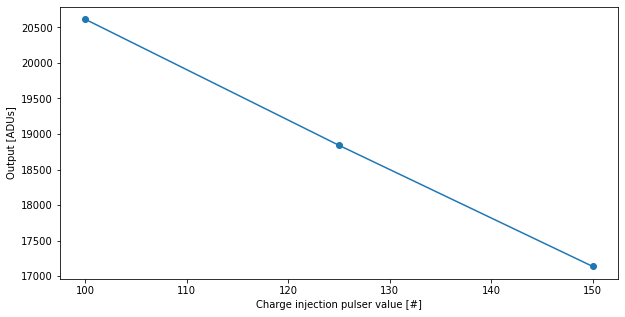

In [52]:
# Fit gain
gain = np.polyfit(ChInjValues, pixelRamp, 1)[0]
print('Gain:{}'.format(gain))

plt.figure(figsize = (10,5))
plt.plot(ChInjValues, pixelRamp,marker='o')
plt.ylabel("Output [ADUs]")
plt.xlabel("Charge injection pulser value [#]")

In [55]:
# stops the spamming of messages
data = readoutFrames(100)

Data Descrambled
(192, 384, 100)


(192, 384)


Text(0.5, 0, 'ADC Value [ADUs]')

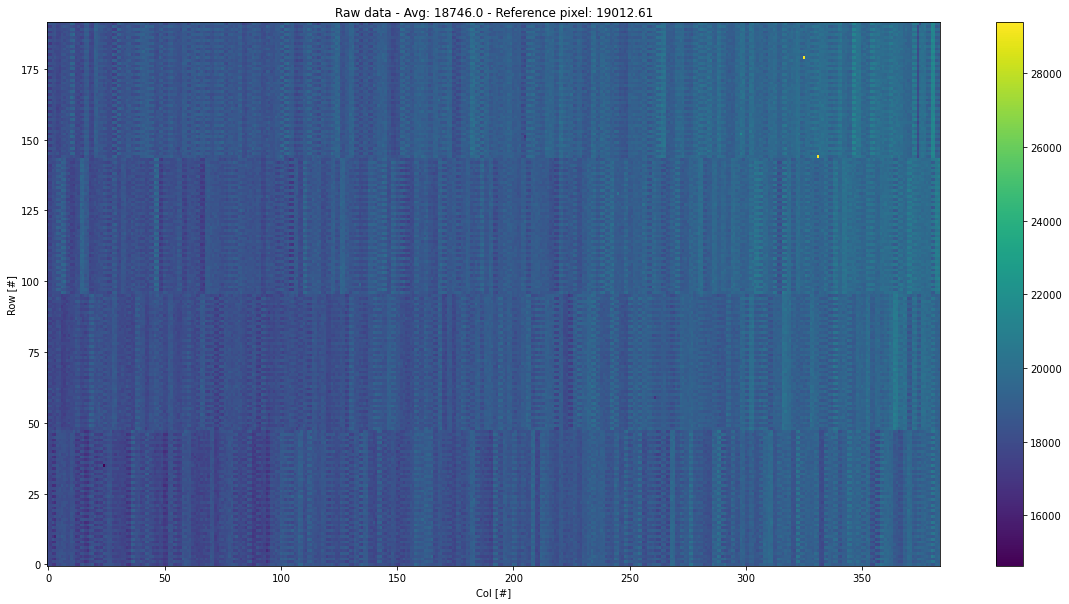

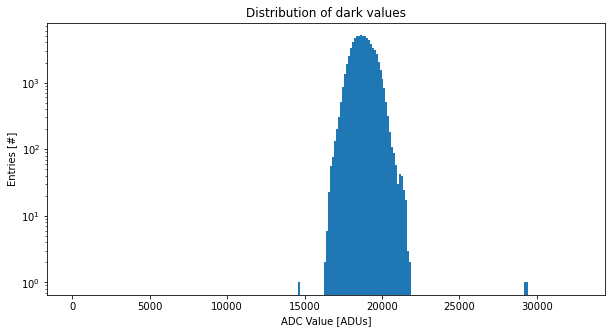

In [56]:
# Plot raw data and histogram

dataTimeAvg = np.average(data,axis=2)

print(np.shape(dataTimeAvg))

plt.figure(figsize = (20,10))
plt.imshow(dataTimeAvg, interpolation='none', aspect='auto', origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title("Raw data - Avg: {:} - Reference pixel: {:}".format(getMedianDark(data),dataTimeAvg[ref_row,ref_col]))
plt.colorbar()


plt.figure(figsize = (10,5))
plt.hist(data[:,:,0].flatten(), range=[0,2**15],bins=2**8, log=True)
plt.title("Distribution of dark values")
plt.ylabel("Entries [#]")
plt.xlabel("ADC Value [ADUs]")


Noise: 25.704029


Text(0.5, 0, 'Noise [ADUs]')

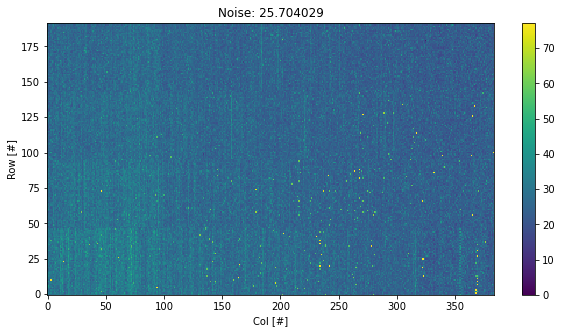

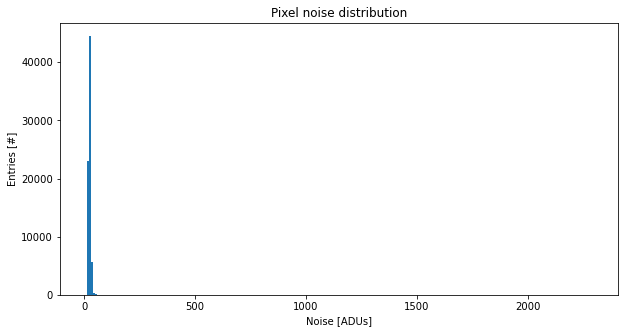

In [57]:
# NOISE

# Uncomment to filter bad pixels!
# data, median_noise = filter_bad_pixels(data)

data_noisemap = np.std(data, axis=2)
median_noise = np.median(data_noisemap)

print('Noise: {:3f}'.format(median_noise))
plt.figure(figsize = (10,5))
plt.imshow(data_noisemap, interpolation='none', aspect='auto', vmin=0, vmax=median_noise*3, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title('Noise: {:3f}'.format(median_noise))
plt.colorbar()

plt.figure(figsize = (10,5))
plt.hist(data_noisemap.flatten(),bins=2**8,)
plt.title("Pixel noise distribution")
plt.ylabel("Entries [#]")
plt.xlabel("Noise [ADUs]")


In [58]:
# Subtract mean and display image
data_darksub = data - np.median(data, axis=2, keepdims=True)

plt.figure(figsize = (20,10))
plt.imshow(data_darksub[:,:,numberOfTriggers-1], interpolation='none', aspect='auto', vmin=-200, vmax=200, origin='lower')
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.colorbar()

NameError: name 'numberOfTriggers' is not defined

<Figure size 1440x720 with 0 Axes>

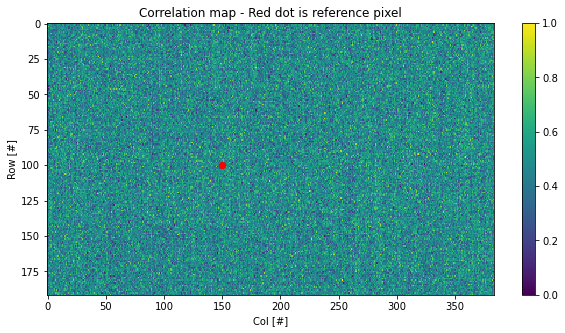

In [26]:
# Plot correlation matrix - Takes some time
correlation = calculate_correlation(data)

plt.figure(figsize = (10,5))
plt.imshow(correlation, interpolation='none', aspect='auto')
plt.scatter(ref_col,ref_row, color='red', s=40)
plt.ylabel("Row [#]")
plt.xlabel("Col [#]")
plt.title('Correlation map - Red dot is reference pixel')
plt.colorbar()

In [27]:
# Disable data debug so it does not store data infinitely and crash software
DEBUG3.cleanData()
print(DEBUG3.getData().shape)
DEBUG3.disableDataDebug()

(192, 384, 0)


AttributeError: 'DataDebug' object has no attribute 'disableDataDebug'

In [ ]:
### Test with parameter scan

DEBUG3.cleanData()
numberOfTriggers = 100

ASIC3.RefinP.set(0)

# For loop over settings
for setting in range(7):

    # Set register
    ASIC3.RefinN.set(setting)
    print('Setting:',setting)
    
    
    for trigNumber in range(numberOfTriggers):
        root.Trigger()
        print("{}".format(trigNumber+1), end='\r')
        time.sleep(0.01)

    # Although the triggers above may have finished, descrambling takes time
    while ( numberOfTriggers != DEBUG3.getData().shape[2]) :
        time.sleep(0.1)
        print("Descrambled {}".format(DEBUG3.getData().shape[2]), end='\r')
    print("Data Descrambled")
    print(DEBUG3.getData().shape)

    # Data format = [row,col,frame_number]
    data = DEBUG3.getData()

    data_noisemap = np.std(data, axis=2)
    median_noise = np.median(data_noisemap)    
    
    print('Noise:',median_noise)
    
    DEBUG3.cleanData()